In [150]:
# imports
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import seaborn as sns
from rich import print
import time
from numba import njit

load_dotenv()


In [153]:
RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PROCESSED_DATA_DIR = Path(os.getenv('PROCESSED_DATA_DIR'))
RANDOM_SEED = 42

In [36]:
views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')
info_df = pl.read_parquet(PROCESSED_DATA_DIR / 'people_data_all.parquet')

In [37]:
views_df

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


In [38]:
info_df

wikidata_code,birth,death,gender,level1_main_occ,name,un_subregion,level2_main_occ,level3_main_occ,bigperiod_birth,bigperiod_death,sum_visib_ln_5criteria,ranking_visib_5criteria,citizenship_1_b,un_region,bplo1,dplo1,bpla1,dpla1,en_label,en_description,worked_at,educated_at,instrument,genre,birth_month,count_gender,count_instrument,count_worked_at,count_country_of_citizenship,count_educated_at,count_occupation,count_genre
str,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,str,str,list[str],list[str],list[str],list[str],str,u32,u32,u32,u32,u32,u32,u32
"""Q1000005""",1860,1927,"""Male""","""Culture""","""Karel_Matěj_Ča…","""Western Europe…","""Culture-core""","""writer""","""4.Mid Modern P…","""5.Contemporary…",23.98061,131428.0,"""Czech_Republic…","""Europe""",12.929798,14.421389,49.440605,50.087502,"""Karel Matěj Ča…","""Czech writer a…",[],[],[],[],"""02""",1,0,0,1,0,4,0
"""Q100005""",1922,1951,"""Male""","""Culture""","""Tadeusz_Borows…","""Eastern Europe…","""Culture-core""","""writer""","""5.Contemporary…","""5.Contemporary…",28.841227,21473.5,"""Poland""","""Europe""",28.657778,21.01111,50.254444,52.23,"""Tadeusz Borows…","""Polish writer …",[],"[""University of Warsaw""]",[],[],"""11""",1,0,0,1,1,5,0
"""Q1000051""",1884,1962,"""Male""","""Leadership""","""Joseph_C._O'Ma…","""Northern Ameri…","""Politics""","""politician""","""4.Mid Modern P…","""5.Contemporary…",23.15431,170792.0,"""US""","""America""",-71.033333,-77.094643,42.391666,38.984825,"""Joseph C. O'Ma…","""American journ…",[],"[""Georgetown University Law Center"", ""Columbia University""]",[],[],"""11""",1,0,0,1,2,3,0
"""Q1000053""",1962,null,"""Male""","""Leadership""","""Vasily_Nebenzy…","""Eastern Europe…","""Administration…","""diplomat""","""5.Contemporary…","""Missing""",25.141882,230781.0,"""Russia""","""Europe""",44.514721,null,48.708611,null,"""Vasily Nebenzy…","""Russian diplom…","[""United Nations""]","[""Moscow State Institute of International Relations""]",[],[],"""02""",1,0,1,2,1,2,0
"""Q1000061""",1940,null,"""Male""","""Leadership""","""Valentyn_Symon…","""Eastern Europe…","""Politics""","""politician""","""5.Contemporary…","""Missing""",23.340572,219961.0,"""Ukraine""","""Europe""",30.73262,null,46.47747,null,"""Valentyn Symon…","""Ukrainian stat…","[""State University of Trade and Economics""]","[""Odesa State Academy of Civil Engineering and Architecture""]",[],[],"""07""",1,0,1,1,1,2,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q999994""",1988,null,"""Male""","""Sports/Games""","""Mitja_Mežnar""","""Southern Europ…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.543238,350041.5,"""Slovenia""","""Europe""",14.35561,null,46.238869,null,"""Mitja Mežnar""","""Slovenian ski …",[],[],[],[],"""06""",1,0,0,1,0,1,0
"""Q999995""",1987,null,"""Male""","""Sports/Games""","""Martin_Cikl""","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.71133,339942.5,"""Czech_Republic…","""Europe""",14.618354,null,50.911613,null,"""Martin Cikl""","""Czech ski jump…",[],[],[],[],"""08""",1,0,0,1,0,1,0
"""Q999997""",1984,null,"""Male""","""Sports/Games""","""Vincent_Descom…","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",24.453411,154890.0,"""France""","""Europe""",6.868889,null,45.922222,null,"""Vincent Descom…","""French ski jum…",[],[],[],[],"""01""",1,0,0,1,0,2,0


In [39]:
info_df['level2_main_occ'].value_counts()

level2_main_occ,count
str,u32
"""Family""",8325
"""Worker/Busines…",12795
"""Culture-core""",380896
"""Military""",47350
"""Religious""",45481
…,…
"""Sports/Games""",525584
"""Politics""",204040
"""Administration…",48954


In [154]:
X = views_df.filter(pl.col('title').is_in(info_df.filter(pl.col('level2_main_occ') == 'Politics').select('name'))).drop('title').drop_nulls().to_numpy()
rng = np.random.default_rng(RANDOM_SEED)
rng.shuffle(X)
X.shape

(132153, 104)

In [41]:
from pyts.approximation import SymbolicAggregateApproximation, SymbolicFourierApproximation, PiecewiseAggregateApproximation
from pyts.decomposition import SingularSpectrumAnalysis

In [171]:
sax_transformer = SymbolicAggregateApproximation(n_bins=2, alphabet='ordinal', strategy='uniform')
X_sax = sax_transformer.transform(X)

pax_transformer = PiecewiseAggregateApproximation(window_size=12, overlapping=False)
X_pax = pax_transformer.transform(X)

ssa_transformer = SingularSpectrumAnalysis(window_size=12, groups='auto')
X_trend, X_seasonal, X_residual = ssa_transformer.fit_transform(X).transpose(1, 0, 2)

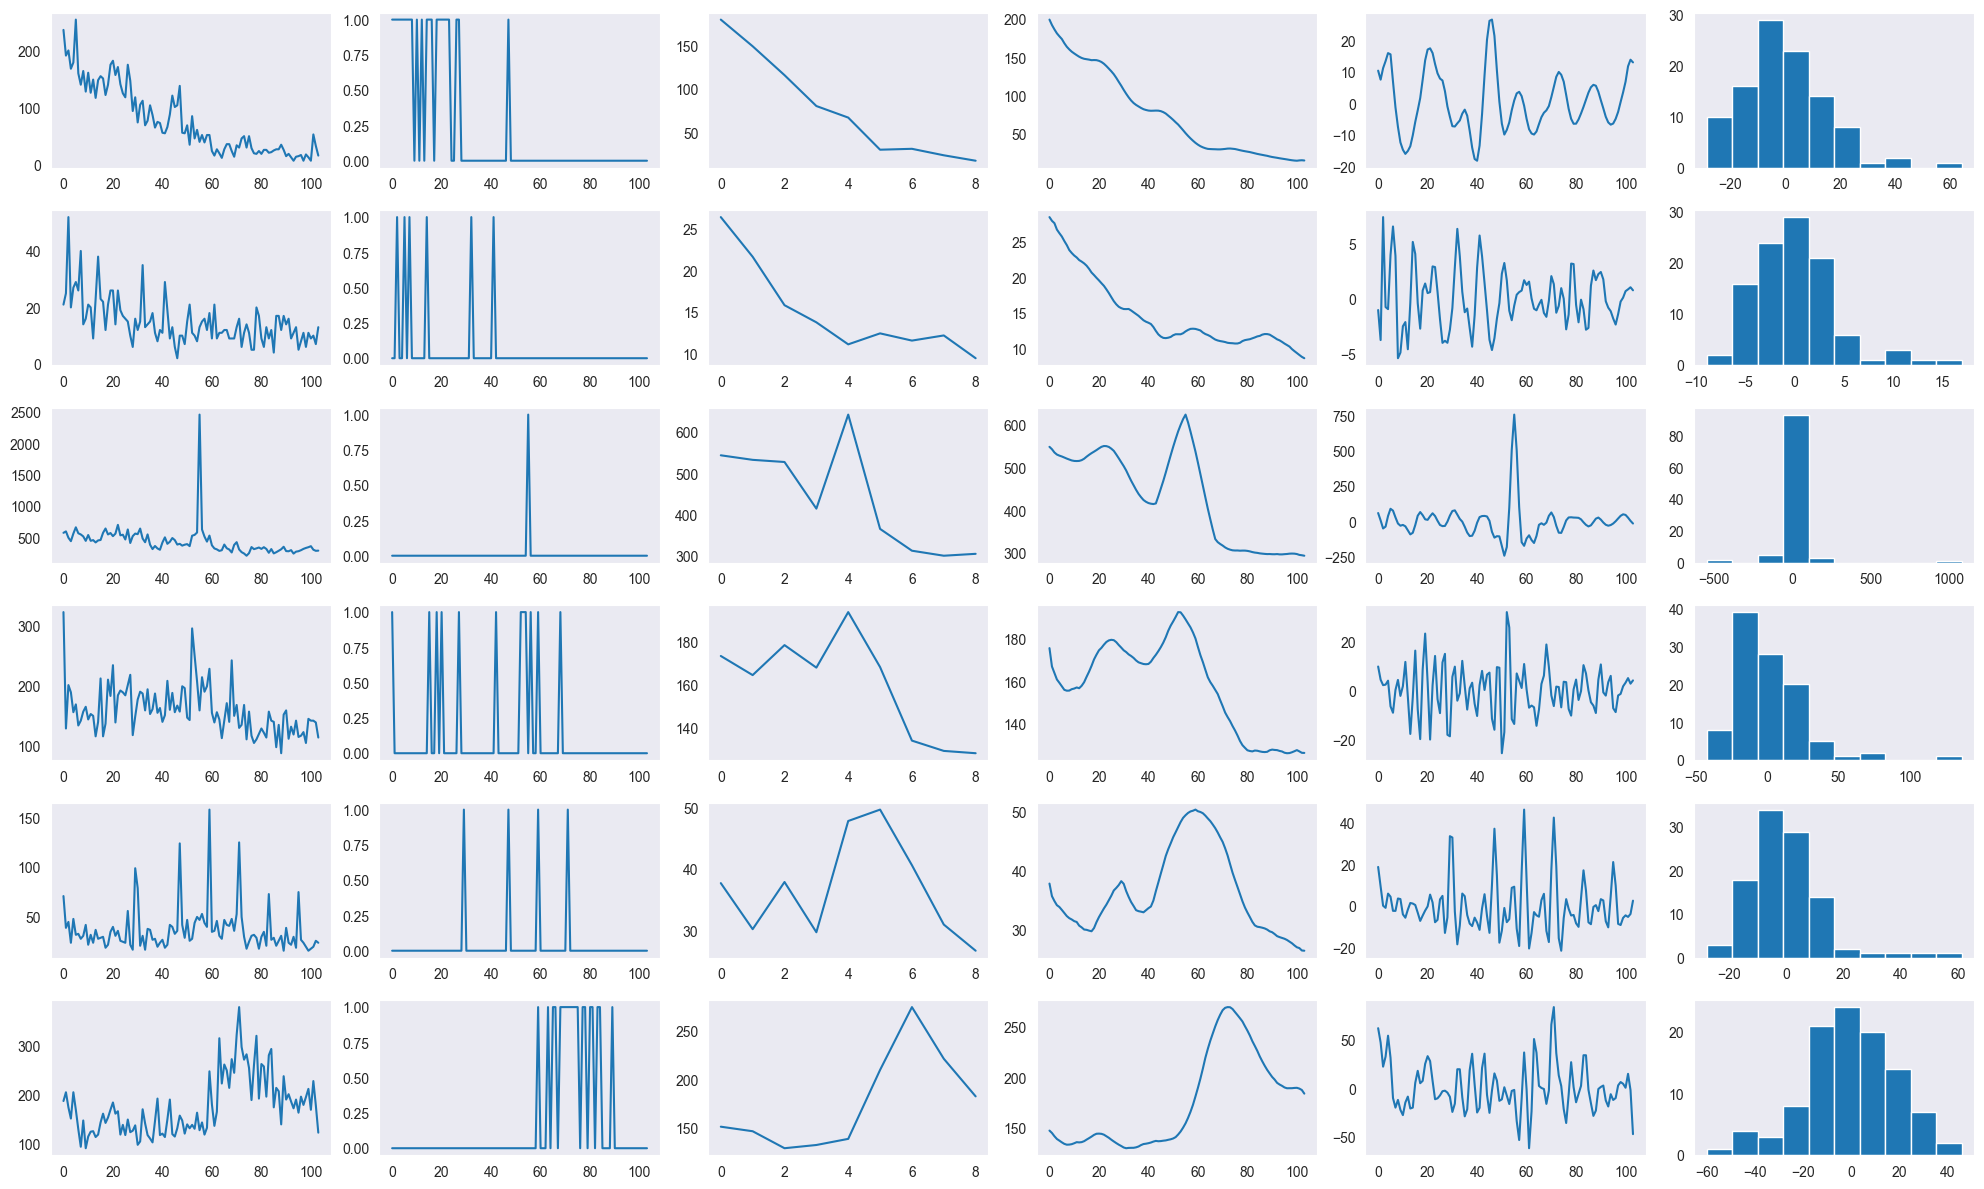

In [174]:
n_to_plot = 6

# rng = np.random.default_rng(RANDOM_SEED)
# sample_idx = rng.integers(0, len(X), n_to_plot)
# sample_idx = [ 11794, 102280,  86503,  57999,  57224] 
sample_idx = np.arange(n_to_plot)

fig, axs = plt.subplots(n_to_plot, 6, figsize=(20, n_to_plot * 2))

all_X = zip(X[sample_idx], X_sax[sample_idx], X_pax[sample_idx], X_trend[sample_idx], X_seasonal[sample_idx], X_residual[sample_idx])
for (x, x_sax, x_pax, x_trend, x_seasonal, x_residual), ax in zip(all_X, axs):
    ax[0].plot(x)
    ax[1].plot(x_sax)
    ax[2].plot(x_pax)
    ax[3].plot(x_trend)
    ax[4].plot(x_seasonal)
    ax[5].hist(x_residual)

plt.tight_layout()
plt.show()

One-hit wonder, nostalgia

In [143]:
@njit
def count_clusters(x_sax: np.ndarray, d: int):
    if x_sax.ndim != 1:
        raise ValueError('array must be 1d')
    nonzero_count = np.count_nonzero(x_sax) 
    if nonzero_count in (0, 1):
        return nonzero_count

    # Calculate the difference between consecutive indices where 1s occur
    diff = np.diff(np.where(x_sax)[0])

    # Count the number of clusters by checking where the difference is greater than d
    num_clusters = np.sum(diff > d)

    # Add 1 to account for the last cluster
    num_clusters += 1 if len(diff) > 0 else 0

    return num_clusters


def count_clusters_2d(X_sax: np.ndarray, d: int):
    return np.apply_along_axis(count_clusters, d=d, arr=X_sax, axis=1).reshape(-1, 1)

Seasonality

In [186]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

def find_seasonality(x: np.ndarray, d, fitter):
    if x.ndim != 1:
        raise ValueError('array must be 1d')
    fitter.fit(x)
    significant_sp = fitter.get_fitted_params()['sp_significant']
    if len(significant_sp) > 0:
        sp_idx = np.argwhere(np.array(significant_sp) > d)
        if len(sp_idx) > 0:
            return significant_sp[sp_idx]
    return None

def find_seasonality_2d(X: np.ndarray, d):
    fitter = Differencer() * SeasonalityACF()
    return np.apply_along_axis(find_seasonality, d=d, fitter=fitter, arr=X, axis=1).reshape(-1, 1)

In [187]:
find_seasonality_2d(X[:50], 3)

array([[None],
       [None],
       [None],
       [None],
       [12],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [12],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [12],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None]], dtype=object)

In [162]:
nobs = len(X[1])
nlags = min(10 * np.log10(nobs), nobs - 1)
print(nlags)

20.170333392987803

Linear trend

In [19]:
from scipy import stats
def regression(x: np.ndarray):
    x = (x - x.mean()) / x.std()
    m = len(x) - 1
    x_range = np.arange(len(x))
    x_range_mean = m / 2
    slope = (x - x.mean()).dot(x_range - x_range_mean) / (m * np.var(x_range))
    intercept =  x.mean() - slope * x_range_mean
    residuals = x - (slope * x_range + intercept)
    rss = np.sum(np.square(residuals))
    tss =  np.sum(np.square(x - x.mean()))
    r2 = 1 - rss / tss
    # pvalue calculation
    se = x.std() / np.sqrt(np.sum(np.square(x_range - x_range_mean)))
    
    stat = slope / se 
    print(stat)
    pv = 2 * (1 - stats.t.cdf(np.abs(stat), m))
    return slope, intercept, r2, pv

In [20]:
# test
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
slope, intercept, r2, pv = regression(x)
print(slope, intercept, r2, pv)

3.5136418446315325
0.3868392354571063 -1.7407765595569784 0.9876543209876544 0.006580848999838018


In [22]:
def simple_linear_regression_per_row(X):
    # TEST THIS
    # Create an array representing the time points (independent variable)
    time_points = np.arange(X.shape[1])

    # Calculate the mean of each row and the mean of the time points
    row_means = np.mean(X, axis=1)
    time_mean = np.mean(time_points)

    # Calculate the numerator and denominator for each row
    numerator = np.sum((time_points - time_mean)
                       [:, np.newaxis] * (X - row_means[:, np.newaxis]), axis=1)
    denominator = np.sum((time_points - time_mean) ** 2)

    # Calculate the slopes
    slopes = numerator / denominator

    # Calculate the intercepts
    intercepts = row_means - slopes * time_mean

    # Calculate the predicted values for each row
    y_preds = intercepts[:, np.newaxis] + slopes[:, np.newaxis] * time_points

    # Calculate the residual sum of squares (RSS) for each row
    rss = np.sum((X - y_preds) ** 2, axis=1)

    # Calculate the total sum of squares (TSS) for each row
    tss = np.sum((X - row_means[:, np.newaxis]) ** 2, axis=1)

    # Calculate R-squared for each row
    r_squared_values = 1 - (rss / tss)

    # Calculate the standard error of the slope for each row
    n = X.shape[1]
    standard_errors = np.sqrt(rss / (n - 2)) / \
        np.sqrt(np.sum((time_points - time_mean) ** 2))

    # Calculate t-values for each row
    t_values = slopes / standard_errors

    # Calculate p-values for each row
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=n - 2))

    return slopes, intercepts, r_squared_values, p_values

In [29]:
simple_linear_regression_per_row(np.array(np.expand_dims(x, 0)))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [212]:
for x in X[:50]:
    print(regression(x))

(-0.03010493834276493, 1.5504043246523938, 0.8011015911637434)

(-0.01897606390969271, 0.9772672913491747, 0.3182910148156459)

(-0.012733664995486853, 0.6557837472675729, 0.14332400987244864)

(-0.014027804048383424, 0.7224319084917467, 0.17393680627269292)

(-0.0018341136686731948, 0.0944568539366697, 0.002973477147361847)

(0.01698832842949721, -0.874898914119106, 0.25510173193041863)

(-0.022713044970252245, 1.1697218159679905, 0.45599788858314894)

(-0.026818121834907397, 1.381133274497731, 0.6357243246146029)

(0.00847242425360887, -0.4363298490608567, 0.0634493971002471)

(-0.0046620953195800775, 0.24009790895837405, 0.01921208093854332)

(-0.017694481826093053, 0.9112658140437924, 0.27675011392142235)

(-0.02151990172821378, 1.1082749390030096, 0.40934800460296716)

(-0.0013009498891910914, 0.06699891929334126, 0.001496005696015601)

(-0.023462288538056014, 1.2083078597098846, 0.4865784302928453)

(-0.021437569700024868, 1.1040348395512807, 0.4062217839046476)

(-0.006662565841994523, 0.34312214086271803, 0.03923694069027861)

(-0.007424535257559357, 0.38236356576430686, 0.048724866526668076)

(-0.027555887619364724, 1.4191282123972833, 0.671182956786988)

(-0.018693986405323028, 0.9627402998741357, 0.3088986108528953)

(-0.02340709743024978, 1.2054655176578637, 0.4842919340847497)

(-0.016628879079175048, 0.8563872725775151, 0.2444207434147624)

(-0.014590572860232966, 0.7514145023019979, 0.18817277844875258)

(-0.006267562000308429, 0.3227794430158841, 0.03472237217476781)

(-0.02463408681761357, 1.2686554711070985, 0.5363954009149379)

(-0.022604692265312684, 1.1641416516636032, 0.45165758522618393)

(-0.01917386083306503, 0.987453832902849, 0.3249610070433967)

(-0.012193360822042846, 0.6279580823352066, 0.13141924298145002)

(-0.004030245990725845, 0.207557668522381, 0.01435738080395177)

(-0.004768517479953884, 0.245578650217625, 0.020099204461396236)

(-0.009647127369040052, 0.49682705950556266, 0.08226368032050835)

(-0.01542178933560719, 0.7942221507837701, 0.21022368414117676)

(-0.007619316960530633, 0.3923948234673275, 0.051314983198069486)

(-0.02527499213755127, 1.3016620950838902, 0.5646692894798464)

(-0.018253282009532464, 0.9400440234909219, 0.29450592559564737)

(-0.020577452276601647, 1.059738792244985, 0.37427887591544307)

(-0.007371589768775456, 0.379636873091936, 0.048032415498259096)

(-0.0014200959054562476, 0.07313493913099678, 0.0017825735603484993)

(-0.017042160471325896, 0.8776712642732836, 0.2567210089458456)

(-0.017135470841878504, 0.8824767483567431, 0.25953993695512845)

(-0.006783257179188972, 0.34933774472823204, 0.04067135827238222)

(0.004976282471757809, -0.25627854729552724, 0.021888810388344337)

(-0.016930790027065584, 0.8719356863938775, 0.2533766311715433)

(-0.011072968523375066, 0.5702578789538159, 0.1083777775557121)

(-0.018002401118659535, 0.9271236576109658, 0.2864659304622772)

(0.008567546293852424, -0.44122863413339997, 0.06488211968426394)

(-0.01865646662141898, 0.9608080310030773, 0.3076599046500035)

(-0.022768354004237688, 1.172570231218241, 0.45822141348832546)

(-0.025654927075211373, 1.3212287443733857, 0.5817731572070339)

(-0.020811843856726523, 1.071809958621416, 0.38285403444904287)

(-0.004634285164734024, 0.23866568598380214, 0.01898355820650166)

In [199]:
regression(np.array([1, 2, 3, 4, 5, 6, 7]))

(1.1666666666666667, 0.5, 0.9722222222222222)

In [323]:
(pl.DataFrame(X_sax[[11794, 102280,  86503,  57999,  57224]]).with_row_index()
 .melt('index')
 .group_by('index')
 .agg(num_peaks=pl.col('value').ts.number_peaks(12))
 .sort('index')
)


index,num_peaks
u32,u32
0,0
1,0
2,2
3,1
4,0


In [89]:
np.diff(np.where(X_sax[57999])[0])

array([ 1,  1,  1,  1,  8, 10,  7, 18, 39], dtype=int64)

In [332]:
import numpy as np
from numpy.polynomial import Polynomial

In [341]:
np.polyfit(np.arange(len(X_sax)), X_sax, deg=1).shape

(2, 104)

In [ ]:
# count number of "0" between "1" in X

def count_zeros_between_ones(X):
    return np.array(
        [np.diff(
            np.where(
                np.concatenate(([0], x, [0])))[0])[::2] for x in X
         ]
        )

In [343]:
# calculate linear coefficient and r2 for each row in X
def calculate_linear_coefficients(X):
    n = X.shape[1]
    coefficients = np.zeros((X.shape[0], n))
    r2 = np.zeros((X.shape[0], n))
    for i in range(X.shape[0]):
        for j in range(n):
            p = Polynomial.fit(np.arange(len(X[i])), X[i], deg=1)
            coefficients[i, j] = p.convert().coef[0]
            r2[i, j] = p.convert().coef[1]
    return coefficients, r2

coefficients, r2 = calculate_linear_coefficients(X_sax)

: 

In [312]:
X_sax[57999]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [220]:
np.apply_along_axis(len, 1, axs)

array([6, 6, 6, 6, 6])

In [168]:
(views_df.filter(pl.col('title').is_in(info_df.filter(pl.col('level2_main_occ') == 'Politics').select('name')))
 .melt('title')
 .group_by('title')
 .agg(linear_trend=pl.col('value').ts.linear_trend())
 .unnest('linear_trend')
)

title,slope,intercept,rss
str,f64,f64,f64
"""John_Shurley_(…",-0.132055,25.483516,37942.020084
"""Kazimierz_Karw…",-0.358231,35.448901,7230.644924
"""H._B._Ari_Gowd…",-0.383548,47.348901,45818.470234
"""Hiroyuki_Tani""",-0.122527,27.839011,618696.746703
"""Raashid_Alvi""",-2.222234,329.82967,7.4868e6
…,…,…,…
"""John_Easton_Mi…",-0.342292,55.57033,16411.909591
"""Psammetichus_I…",0.119722,89.517033,41639.073578
"""Rosa_Valenzuel…",-0.236648,29.43979,7737.81983


In [108]:
pl.DataFrame(X_sax[0])

column_0
i64
5665
2932
2420
2482
3097
…
1026
1335
5767


In [107]:
import polars as pl
import numpy as np
from functime.feature_extractors import FeatureExtractor, binned_entropy

# Load commodities price data
y = pl.read_parquet(
    "https://github.com/functime-org/functime/raw/main/data/commodities.parquet")

# Get column names ("commodity_type", "time", "price")
entity_col, time_col, value_col = y.columns

# Extract a single feature from a single time-series
binned_entropy = binned_entropy(
    pl.Series(np.random.normal(0, 1, size=10)),
    bin_count=10
)

# 🔥 Also works on LazyFrames with query optimization
features = (
    pl.LazyFrame({
        "index": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
        "value": np.random.normal(0, 1, size=10)
    })
    .select(
        binned_entropy=pl.col("value").ts.binned_entropy(bin_count=10),
        cusum=pl.col('value').ts.cusum(10, 10),
        lempel_ziv_complexity=pl.col(
            "value").ts.lempel_ziv_complexity(threshold=3),
        longest_streak_above_mean=pl.col(
            "value").ts.longest_streak_above_mean(),
    )
    .collect()
)

# 🚄 Extract features blazingly fast on many
# stacked time-series using `group_by`
features = (
    y.group_by(entity_col)
    .agg(
        binned_entropy=pl.col(value_col).ts.binned_entropy(bin_count=10),
        lempel_ziv_complexity=pl.col(
            value_col).ts.lempel_ziv_complexity(threshold=3),
        longest_streak_above_mean=pl.col(
            value_col).ts.longest_streak_above_mean(),
    )
)

# 🚄 Extract features blazingly fast on windows
# of many time-series using `group_by_dynamic`
features = (
    # Compute rolling features at yearly intervals
    y.group_by_dynamic(
        time_col,
        every="12mo",
        by=entity_col,
    )
    .agg(
        binned_entropy=pl.col(value_col).ts.binned_entropy(bin_count=10),
        lempel_ziv_complexity=pl.col(
            value_col).ts.lempel_ziv_complexity(threshold=3),
        longest_streak_above_mean=pl.col(
            value_col).ts.longest_streak_above_mean(),
    )
)

features

C:\Users\netan\AppData\Local\Temp\ipykernel_12268\2558532157.py:52: DeprecationWarning: `the argument by` for `group_by_dynamic` is deprecated. It has been renamed to `group_by`.
  y.group_by_dynamic(


commodity_type,time,binned_entropy,lempel_ziv_complexity,longest_streak_above_mean
str,datetime[ns],f64,f64,i32
"""Aluminum""",1960-01-01 00:00:00,0.0,0.333333,0
"""Aluminum""",1961-01-01 00:00:00,0.0,0.333333,0
"""Aluminum""",1962-01-01 00:00:00,0.566086,0.333333,2
"""Aluminum""",1963-01-01 00:00:00,0.562335,0.333333,3
"""Aluminum""",1964-01-01 00:00:00,0.983088,0.333333,9
…,…,…,…,…
"""Zinc""",2019-01-01 00:00:00,1.820076,0.333333,6
"""Zinc""",2020-01-01 00:00:00,1.979205,0.333333,5
"""Zinc""",2021-01-01 00:00:00,1.748155,0.333333,4


In [161]:
y.group_by('commodity_type').agg(trend=pl.col('time').ts.linear_trend())

commodity_type,trend
str,struct[3]
"""Copper""","{2.6298e15,-3.1565e17,2.7060e30}"
"""Logs, Cameroon…","{2.6298e15,-7.2523e13,2.2912e30}"
"""Rice, Viet Nam…","{2.7459e15,1.0811e18,1.2182e34}"
"""Sawnwood, Mala…","{2.6298e15,-3.1565e17,2.7060e30}"
"""Zinc""","{2.6298e15,-3.1565e17,2.7060e30}"
…,…
"""Sawnwood, Came…","{3.2537e15,4.9819e17,5.3166e36}"
"""Urea ""","{2.6298e15,-3.1565e17,2.7060e30}"
"""Crude oil, ave…","{2.6298e15,-3.1565e17,2.7060e30}"


----

## Patterns

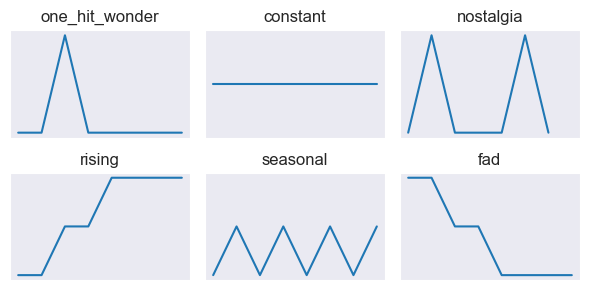

In [34]:
import seaborn as sns
patterns = {
    'one_hit_wonder': [0, 0, 2, 0, 0, 0, 0, 0],
    'constant': [1, 1, 1, 1, 1, 1, 1, 1],
    'nostalgia': [0, 2, 0, 0, 0, 2, 0],
    'rising': [0, 0, 1, 1, 2, 2, 2, 2],
    'seasonal': [0, 1, 0, 1, 0, 1, 0, 1],
    'fad': [2, 2, 1, 1, 0, 0, 0, 0],
    
}

fig, axs = plt.subplots(2, len(patterns) // 2, figsize=(len(patterns), 3), sharex=True, sharey=True)
for (name, pattern), ax in zip(patterns.items(), axs.ravel()):
    sns.lineplot(pattern, ax=ax)
    ax.set(title=name, xticklabels='', yticklabels='')
plt.tight_layout()
plt.show()

```
x_sax = sax(x)
if number of peaks in X_sax == 1:
    classify x as one_hit_wonder
else if number of peaks in X_sax == 2:
    classify x as nostalgia
else:
    find seasonality
    else:
        if linear regression pvalue < 0.5>:
            if linear slope < 0:
                classify x as fad
            else if linear slope > 0:
                classify as rising
        else:
            classify as constant


```